In [ ]:
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import datetime
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Read in the json file that has Spotify api credentials 
with open('../info.json', 'r') as info_file:
    info = json.load(info_file)
client_id = info['client_id'] 
client_secret = info['client_secret']

#Set up Spotify client credentials manager using clientID and cleint secret
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
#Create Spotify client object
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
def get_recent_albums_last_5_years(sp, limit=50, years_back=5, pages=5):
    albums_data = []

    # Get current year
    current_year = datetime.datetime.now().year
    
    # Loop through the past 'years_back' years
    for year in range(current_year - years_back, current_year + 1):
        query = f"year:{year}"
        offset = 0
        
        # Loop through the pages
        for page in range(pages):
            results = sp.search(q=query, type='album', limit=limit, offset=offset)

            for album in results['albums']['items']:
                album_id = album['id']
                album_name = album['name']
                release_date = album['release_date']
                total_tracks = album['total_tracks']
                image_url = album['images'][0]['url'] if album['images'] else None
                artist_name = album['artists'][0]['name']

                # Get album popularity
                album_info = sp.album(album_id)
                popularity = album_info['popularity']

                albums_data.append({
                    'album_id': album_id,
                    'album_name': album_name,
                    'artist_name': artist_name,
                    'release_date': release_date,
                    'total_tracks': total_tracks,
                    'popularity': popularity,
                    'image_url': image_url
                })

            # Increment offset for the next page
            offset += limit
            time.sleep(1)

    return albums_data

# Fetch data
albums = get_recent_albums_last_5_years(sp)

# Write to CSV
csv_filename = 'recent_albums_last_5_years.csv'
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=albums[0].keys())
    writer.writeheader()
    writer.writerows(albums)

print(f"Saved {len(albums)} albums to {csv_filename}")

Saved 1500 albums to recent_albums_last_5_years.csv


In [ ]:
# Read the data from the CSV file
df = pd.read_csv('recent_albums_last_5_years.csv')

# Try converting release_date to datetime, but handle errors
def parse_date(date):
    try:
        return pd.to_datetime(date)
    except:
        # If conversion fails (e.g., only year given), return first day of the year
        return pd.to_datetime(f'{date}-01-01', errors='coerce')

# Apply the function to the 'release_date' column
df['release_date'] = df['release_date'].apply(parse_date)

# Create a new column combining year and month
df['release_month_year'] = df['release_date'].dt.to_period('M')

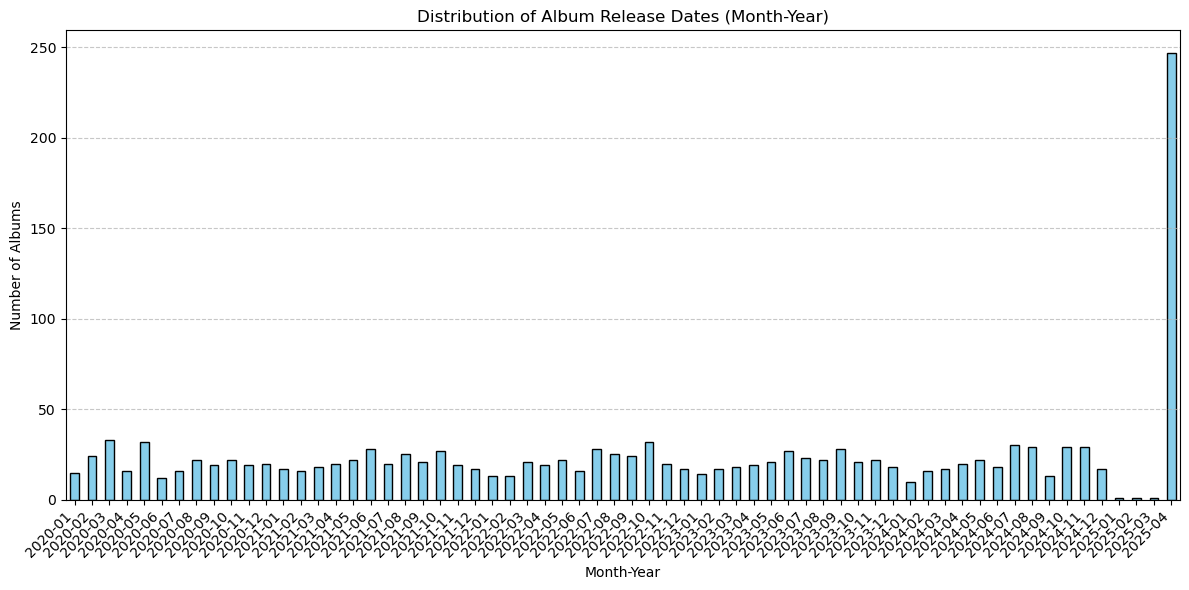

In [10]:
# Plot distribution of album release months and years
plt.figure(figsize=(12, 6))
df['release_month_year'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Album Release Dates (Month-Year)')
plt.xlabel('Month-Year')
plt.ylabel('Number of Albums')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

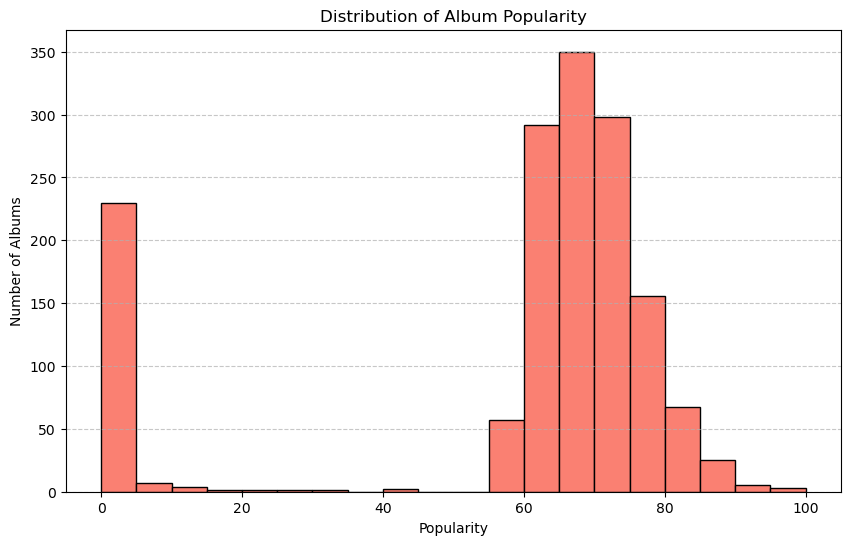

In [8]:
# Plot distribution of album popularity
plt.figure(figsize=(10, 6))
plt.hist(df['popularity'], bins=20, edgecolor='black', color='salmon')
plt.title('Distribution of Album Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Albums')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()